In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import boxcox
pd.options.display.max_rows = 100


from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split



from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd


In [22]:
df = pd.read_csv('Data_Marketing_Customer_Analysis_Round3 copy.csv')

- Get the numeric data into dataframe called `numerical` and categorical columns in a dataframe called `categoricals`.
THEN TASK 1 check if there are highly correlated features and drop them if there are any.

In [23]:

numerical = df.select_dtypes(include = np.number)
numerical.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10689 entries, 0 to 10688
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   customer_lifetime_value        10689 non-null  int64
 1   income                         10689 non-null  int64
 2   monthly_premium_auto           10689 non-null  int64
 3   months_since_last_claim        10689 non-null  int64
 4   months_since_policy_inception  10689 non-null  int64
 5   number_of_open_complaints      10689 non-null  int64
 6   number_of_policies             10689 non-null  int64
 7   total_claim_amount             10689 non-null  int64
dtypes: int64(8)
memory usage: 668.2 KB


In [24]:
categoricals = df.select_dtypes(include = np.object)
categoricals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10689 entries, 0 to 10688
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   region             10689 non-null  object
 1   response           10689 non-null  object
 2   coverage           10689 non-null  object
 3   education          10689 non-null  object
 4   effective_to_date  10689 non-null  object
 5   month              10689 non-null  object
 6   employment_status  10689 non-null  object
 7   gender             10689 non-null  object
 8   location_code      10689 non-null  object
 9   marital_status     10689 non-null  object
 10  policy_type        10689 non-null  object
 11  policy             10689 non-null  object
 12  renew_offer_type   10689 non-null  object
 13  sales_channel      10689 non-null  object
 14  vehicle_class      10689 non-null  object
 15  vehicle_size       10689 non-null  object
dtypes: object(16)
memory usage: 1.3+ MB


/var/folders/k8/l3hrl_fn5y7bx5qcfv9y8p900000gn/T/ipykernel_14334/2767949428.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categoricals = df.select_dtypes(include = np.object)


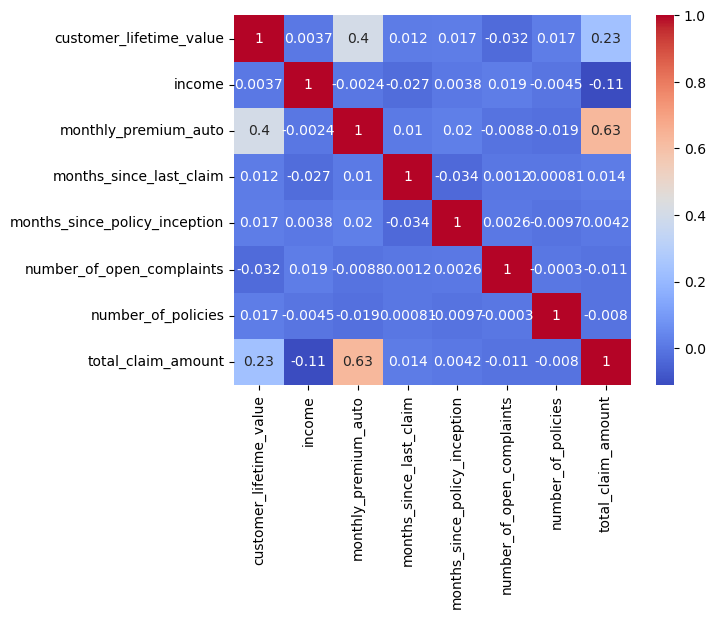

In [25]:

# compute the correlation matrix
corr_matrix = numerical.corr()

# plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

# highest correlation us 0,63 so  do not need to drop any columns, as only above 0,9 is needed

In [26]:
categoricals = categoricals.drop('effective_to_date', axis=1)
categoricals

,region,response,coverage,education,month,employment_status,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,central,no,basic,college,feb,employed,m,suburban,married,corporate auto,corporate l3,offer3,agent,four-door car,medsize
1,west region,no,basic,college,jan,unemployed,f,suburban,single,personal auto,personal l3,offer4,call center,four-door car,medsize
2,east,no,basic,bachelor,feb,employed,m,suburban,single,personal auto,personal l3,offer3,call center,suv,medsize
3,north west,yes,extended,college,jan,employed,m,suburban,single,corporate auto,corporate l3,offer2,branch,four-door car,medsize
4,north west,no,premium,bachelor,jan,medical leave,f,suburban,married,personal auto,personal l2,offer1,branch,four-door car,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,central,no,premium,bachelor,jan,unemployed,f,suburban,married,personal auto,personal l1,offer3,web,luxury car,medsize
10685,north west,no,basic,college,jan,employed,f,urban,married,personal auto,personal l3,offer2,branch,four-door car,medsize
10686,central,no,extended,bachelor,feb,employed,f,rural,married,corporate auto,corporate l3,offer1,web,luxury suv,medsize
10687,west region,no,premium,college,feb,employed,f,urban,divorced,personal auto,personal l1,offer1,branch,suv,medsize


In [27]:
# ordinals encoding - the data that would be good to have a idea of hierarchy of and reduce the amount of columns 
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[['basic', 'extended', 'premium'], ['high school or below', 'college', 'bachelor', 'master', 'doctor'], ['small', 'medsize', 'large']])
encoder.fit(categoricals[['coverage', 'education', 'vehicle_size']])

encoded_cols = encoder.transform(categoricals[['coverage', 'education', 'vehicle_size']])

encoded_cols

array([[0., 1., 1.],
       [0., 1., 1.],
       [0., 2., 1.],
       ...,
       [1., 2., 1.],
       [2., 1., 1.],
       [0., 2., 1.]])

In [28]:
encoded_cols = pd.DataFrame(encoded_cols, columns = ['coverage','education','vehicle_size'])

In [29]:
categoricals_encoded = pd.get_dummies(categoricals, drop_first=True)
categoricals_joined = pd.concat([categoricals_encoded,encoded_cols], axis=1)

In [30]:
categoricals_joined

,region_east,region_north west,region_west region,response_yes,coverage_extended,coverage_premium,education_college,education_doctor,education_high school or below,education_master,...,vehicle_class_luxury car,vehicle_class_luxury suv,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car,vehicle_size_medsize,vehicle_size_small,coverage,education,vehicle_size
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0.0,1.0,1.0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0.0,1.0,1.0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0.0,2.0,1.0
3,0,1,0,1,1,0,1,0,0,0,...,0,0,0,0,0,1,0,1.0,1.0,1.0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,2.0,2.0,1.0
10685,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0.0,1.0,1.0
10686,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,1.0,2.0,1.0
10687,0,0,1,0,0,1,1,0,0,0,...,0,0,0,1,0,1,0,2.0,1.0,1.0


array([[<AxesSubplot:title={'center':'customer_lifetime_value'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'monthly_premium_auto'}>],
       [<AxesSubplot:title={'center':'months_since_last_claim'}>,
        <AxesSubplot:title={'center':'months_since_policy_inception'}>,
        <AxesSubplot:title={'center':'number_of_open_complaints'}>],
       [<AxesSubplot:title={'center':'number_of_policies'}>,
        <AxesSubplot:title={'center':'total_claim_amount'}>,
        <AxesSubplot:>]], dtype=object)

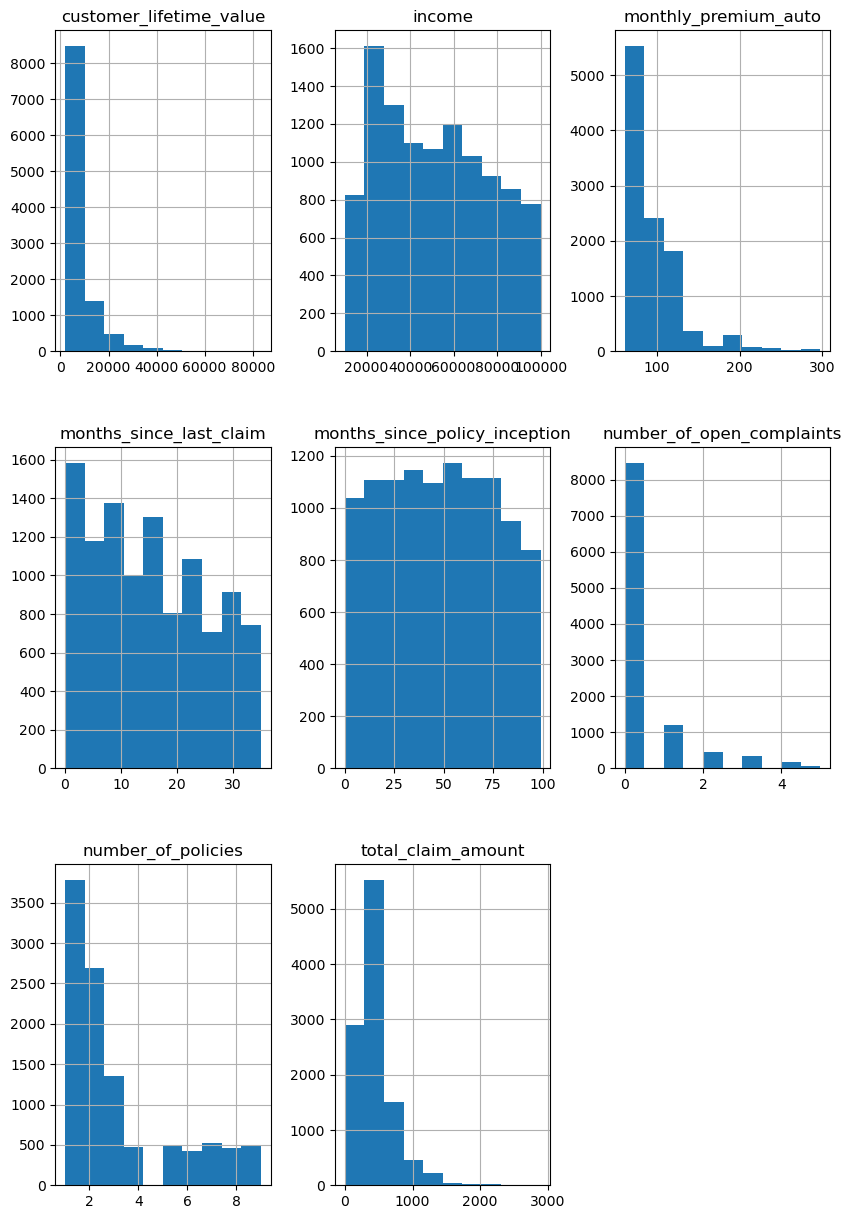

In [31]:
numerical.hist(figsize=(10,15))

Min value of varA_scaled: 0.0
Max value of varB_scaled: 1.0


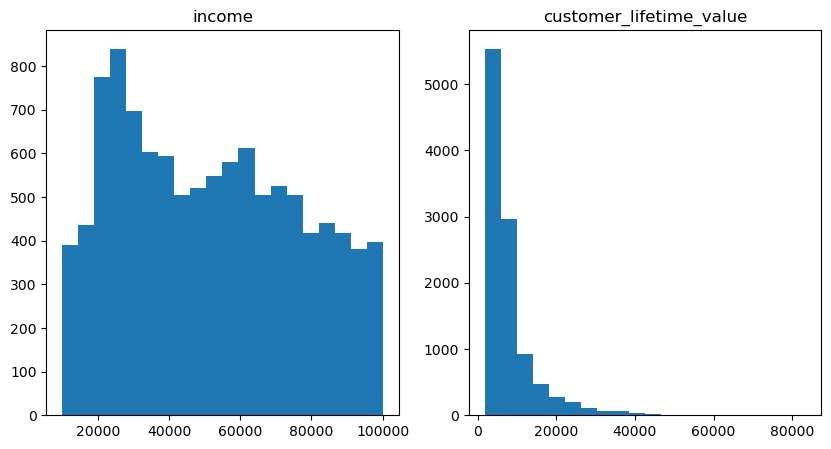

In [32]:
# select variables
varA = 'income'
varB = 'customer_lifetime_value'

from sklearn.preprocessing import minmax_scale

# Apply min-max scaling to varA
varA_scaled = minmax_scale(numerical['income'])
varB_scaled = minmax_scale(numerical['customer_lifetime_value'])

# Print the min and max values of the scaled varA
print("Min value of varA_scaled:", varA_scaled.min())
print("Max value of varB_scaled:", varB_scaled.max())

# create histograms
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(numerical[varA], bins=20)
axs[0].set_title(varA)

axs[1].hist(numerical[varB], bins=20)
axs[1].set_title(varB)

plt.show()

Mean of customer_lifetime_value_boxcox: -3.7951575541939e-15
Mean of income_boxcox: -3.292550274171341e-17
Std of customer_lifetime_value_boxcox: 0.999999999999997
Std of income_boxcox: 0.999999999999998
Skewness of customer_lifetime_value_boxcox: 0.0433917788432849
Skewness of income_boxcox: -0.11103268351896158
Mean of customer_lifetime_value_yeo: 4.192688856775909e-15
Mean of income_yeo: 1.5440710528653361e-16
Std of customer_lifetime_value_yeo: 1.000000000000001
Std of income_yeo: 1.0000000000000009
Skewness of customer_lifetime_value_yeo: 0.04341600860309783
Skewness of income_yeo: -0.11102838291637904


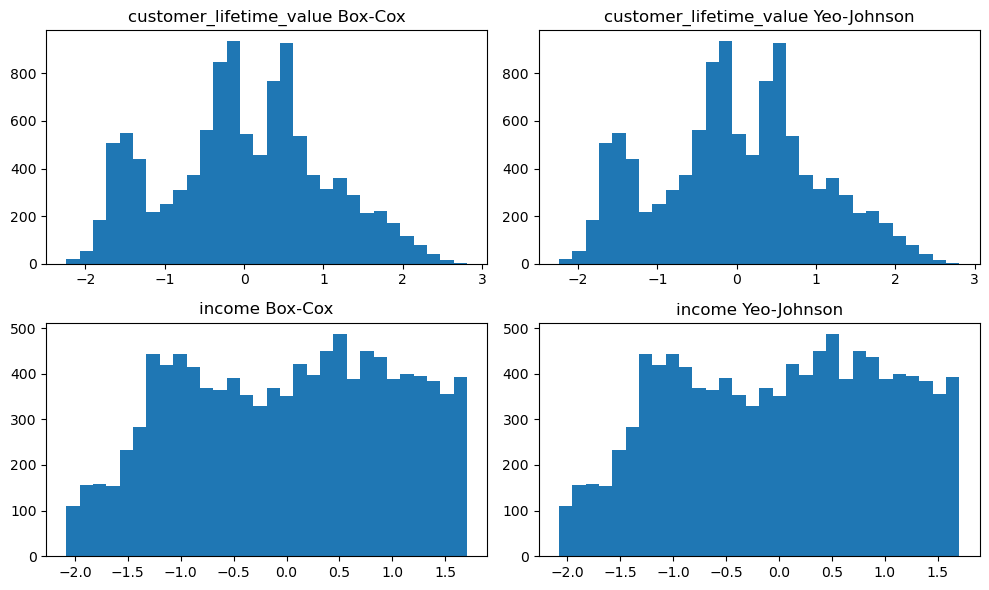

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PowerTransformer

# Load data
data = pd.read_csv('Data_Marketing_Customer_Analysis_Round3 copy.csv')

# Select a numerical feature with a wide range of values
varA = 'customer_lifetime_value'
# Select a numerical feature with a noticeably large skew
varB = 'income'

# Box-Cox transformation
pt = PowerTransformer(method='box-cox')
data[varA+'_boxcox'] = pt.fit_transform(data[[varA]])
data[varB+'_boxcox'] = pt.fit_transform(data[[varB]])

# Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
data[varA+'_yeo'] = pt.fit_transform(data[[varA]])
data[varB+'_yeo'] = pt.fit_transform(data[[varB]])

# Check mean, std, and skewness
print(f'Mean of {varA}_boxcox:', np.mean(data[varA+'_boxcox']))
print(f'Mean of {varB}_boxcox:', np.mean(data[varB+'_boxcox']))
print(f'Std of {varA}_boxcox:', np.std(data[varA+'_boxcox']))
print(f'Std of {varB}_boxcox:', np.std(data[varB+'_boxcox']))
print(f'Skewness of {varA}_boxcox:', stats.skew(data[varA+'_boxcox']))
print(f'Skewness of {varB}_boxcox:', stats.skew(data[varB+'_boxcox']))

print(f'Mean of {varA}_yeo:', np.mean(data[varA+'_yeo']))
print(f'Mean of {varB}_yeo:', np.mean(data[varB+'_yeo']))
print(f'Std of {varA}_yeo:', np.std(data[varA+'_yeo']))
print(f'Std of {varB}_yeo:', np.std(data[varB+'_yeo']))
print(f'Skewness of {varA}_yeo:', stats.skew(data[varA+'_yeo']))
print(f'Skewness of {varB}_yeo:', stats.skew(data[varB+'_yeo']))

# Plot PDF
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0, 0].hist(data[varA+'_boxcox'], bins=30)
axes[0, 0].set_title(f'{varA} Box-Cox')
axes[0, 1].hist(data[varA+'_yeo'], bins=30)
axes[0, 1].set_title(f'{varA} Yeo-Johnson')
axes[1, 0].hist(data[varB+'_boxcox'], bins=30)
axes[1, 0].set_title(f'{varB} Box-Cox')
axes[1, 1].hist(data[varB+'_yeo'], bins=30)
axes[1, 1].set_title(f'{varB} Yeo-Johnson')
plt.tight_layout()
plt.show()

In [34]:
numerical.head()

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,4809,48029,61,7,52,0,9,292
1,2228,92260,64,3,26,0,1,744
2,14947,22139,100,34,31,0,2,480
3,22332,49078,97,10,3,0,2,484
4,9025,23675,117,33,31,0,7,707


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

RAND_STATE = 100 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

# Step 1: Split the data into training and test sets
X = numerical.drop('total_claim_amount', axis=1)
y = numerical.total_claim_amount
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)

# Step 2: Fit the StandardScaler on the training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


# Step 3: Transform the test set using the fitted scaler
test_scaled = scaler.transform(X_test)

# Fit the Linear Regression model on the scaled training data and evaluate on the scaled test data
model = LinearRegression()
model.fit(X_train_scaled, y_train)
score = model.score(pd.DataFrame(test_scaled, columns=X_test.columns), y_test)



/Users/justynakurach/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [37]:
score

0.411756903438649

In [38]:
y_pred = pd.DataFrame(model.predict(test_scaled),columns = ['total_claim_amount'] )      # model prediction
y_pred_train =  pd.DataFrame(model.predict(X_train_scaled),columns = ['total_claim_amount'])

In [39]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))
##prediction on the train set
print(mse(y_train,y_pred_train))
51.0791008107652

50661.02156683923
152.9069517936399
50466.29164229992


51.0791008107652

In [40]:
R2=r2_score(y_test,y_pred)
R2

0.411756903438649

In [41]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_.reshape(len(X_train.columns),))
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances

,Attribute,Importance
2,monthly_premium_auto,186.291580
1,income,31.726777
0,customer_lifetime_value,6.141861
6,number_of_policies,3.241690
5,number_of_open_complaints,2.213876
3,months_since_last_claim,1.661823
4,months_since_policy_inception,1.479246


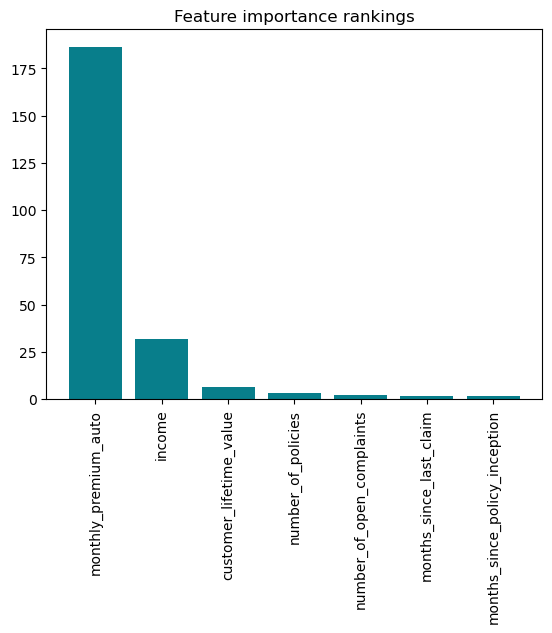

In [42]:
plt.bar(x=features_importances['Attribute'].iloc[:10], height=features_importances['Importance'].iloc[:10], color='#087E8B')
plt.title('Feature importance rankings', size=12)
plt.xticks(rotation='vertical')
plt.show()

In [44]:
numerical

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,4809,48029,61,7,52,0,9,292
1,2228,92260,64,3,26,0,1,744
2,14947,22139,100,34,31,0,2,480
3,22332,49078,97,10,3,0,2,484
4,9025,23675,117,33,31,0,7,707
...,...,...,...,...,...,...,...,...
10684,15563,61541,253,12,40,0,7,1214
10685,5259,61146,65,7,68,0,6,273
10686,23893,39837,201,11,63,0,2,381
10687,11971,64195,158,0,27,4,6,618


In [46]:
categoricals_joined

,region_east,region_north west,region_west region,response_yes,coverage_extended,coverage_premium,education_college,education_doctor,education_high school or below,education_master,...,vehicle_class_luxury car,vehicle_class_luxury suv,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car,vehicle_size_medsize,vehicle_size_small,coverage,education,vehicle_size
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0.0,1.0,1.0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0.0,1.0,1.0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0.0,2.0,1.0
3,0,1,0,1,1,0,1,0,0,0,...,0,0,0,0,0,1,0,1.0,1.0,1.0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,2.0,2.0,1.0
10685,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0.0,1.0,1.0
10686,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,1.0,2.0,1.0
10687,0,0,1,0,0,1,1,0,0,0,...,0,0,0,1,0,1,0,2.0,1.0,1.0


In [48]:
added_df = pd.concat([categoricals_joined,numerical], axis=1)

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

RAND_STATE = 100 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

# Step 1: Split the data into training and test sets
X = added_df.drop('total_claim_amount', axis=1)
y = added_df.total_claim_amount
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)

# Step 2: Fit the StandardScaler on the training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


# Step 3: Transform the test set using the fitted scaler
test_scaled = scaler.transform(X_test)

# Fit the Linear Regression model on the scaled training data and evaluate on the scaled test data
model = LinearRegression()
model.fit(X_train_scaled, y_train)
score = model.score(pd.DataFrame(test_scaled, columns=X_test.columns), y_test)



/Users/justynakurach/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [50]:
y_pred = pd.DataFrame(model.predict(test_scaled),columns = ['total_claim_amount'] )      # model prediction
y_pred_train =  pd.DataFrame(model.predict(X_train_scaled),columns = ['total_claim_amount'])

In [51]:
R2=r2_score(y_test,y_pred)
R2

0.7706551139585684